## Reference Annotation
## https://keras.io/examples/vision/image_classification_from_scratch/

In [1]:
!rm *.h5 *.docx *.
!rm -rf PetImages/
!rm *.zip

In [1]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  98.1M      0  0:00:08  0:00:08 --:--:--  103M
 kagglecatsanddogs_3367a.zip   PetImages        Untitled.ipynb
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [2]:
!ls PetImages

Cat  Dog


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os


In [2]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


2021-09-26 21:11:14.278648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


2021-09-26 21:11:14.284367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 21:11:14.284991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 21:11:14.286366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-26 21:11:14.286722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2021-09-26 21:11:15.398006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


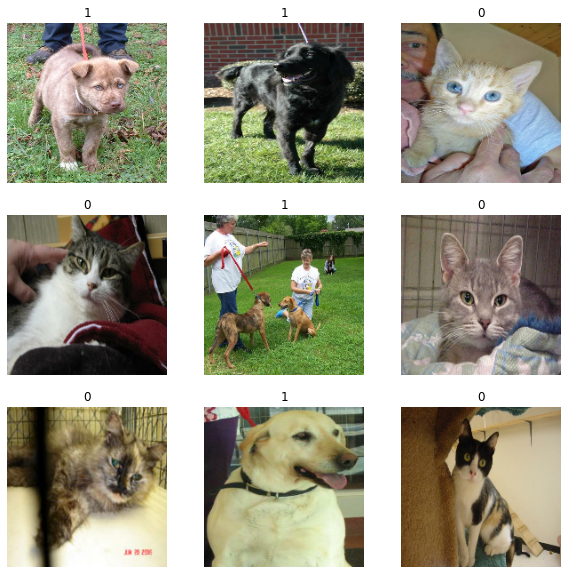

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


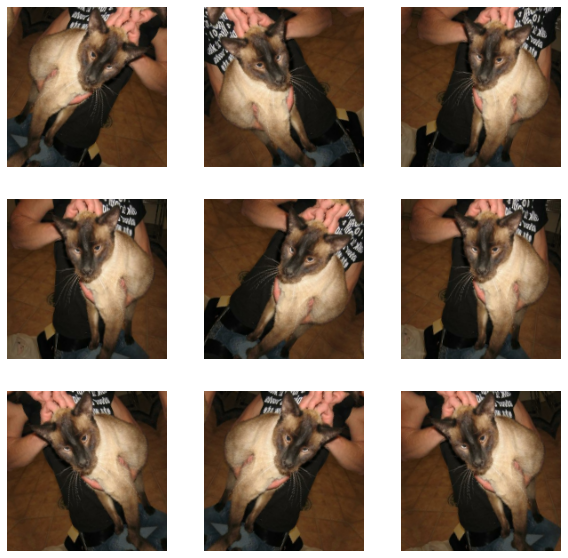

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [7]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2021-09-26 21:11:18.050749: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


294/586 [==============>...............] - ETA: 46s - loss: 0.6781 - accuracy: 0.6203

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.6693 - accuracy: 0.6279

403/586 [===================>..........] - ETA: 29s - loss: 0.6481 - accuracy: 0.6462

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.6460 - accuracy: 0.6481

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.6433 - accuracy: 0.6499

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.6415 - accuracy: 0.6512

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.6695

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 102s 169ms/step - loss: 0.6196 - accuracy: 0.6695 - val_loss: 0.7472 - val_accuracy: 0.5880
Epoch 2/50


/home/willy102425/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.5002 - accuracy: 0.7561

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.4964 - accuracy: 0.7581

403/586 [===================>..........] - ETA: 29s - loss: 0.4864 - accuracy: 0.7643

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.4868 - accuracy: 0.7637

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.4835 - accuracy: 0.7660

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.4837 - accuracy: 0.7660

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.4688 - accuracy: 0.7768

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.4688 - accuracy: 0.7768 - val_loss: 0.4259 - val_accuracy: 0.8178
Epoch 3/50
  1/586 [..............................] - ETA: 1:53 - loss: 0.5273 - accuracy: 0.8125

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.4128 - accuracy: 0.8115

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.4093 - accuracy: 0.8138

402/586 [===================>..........] - ETA: 29s - loss: 0.4045 - accuracy: 0.8182

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.4033 - accuracy: 0.8190

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.4022 - accuracy: 0.8200

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 24s - loss: 0.4019 - accuracy: 0.8201

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8254

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.3911 - accuracy: 0.8254 - val_loss: 0.4512 - val_accuracy: 0.7930
Epoch 4/50
  1/586 [..............................] - ETA: 1:53 - loss: 0.3407 - accuracy: 0.8125

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.3305 - accuracy: 0.8597

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.3281 - accuracy: 0.8602

403/586 [===================>..........] - ETA: 29s - loss: 0.3279 - accuracy: 0.8610

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.3261 - accuracy: 0.8619

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.3267 - accuracy: 0.8614

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.3255 - accuracy: 0.8619

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8654

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.3156 - accuracy: 0.8654 - val_loss: 0.3046 - val_accuracy: 0.8667
Epoch 5/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.2653 - accuracy: 0.8438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.2577 - accuracy: 0.8889

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.2558 - accuracy: 0.8897

403/586 [===================>..........] - ETA: 29s - loss: 0.2618 - accuracy: 0.8886

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.2606 - accuracy: 0.8891

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.2585 - accuracy: 0.8902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.2594 - accuracy: 0.8899

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2545 - accuracy: 0.8919

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.2544 - accuracy: 0.8919 - val_loss: 0.5007 - val_accuracy: 0.7933
Epoch 6/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.1955 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.2340 - accuracy: 0.8989

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.2297 - accuracy: 0.9005

402/586 [===================>..........] - ETA: 29s - loss: 0.2334 - accuracy: 0.8994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.2323 - accuracy: 0.9002

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.2308 - accuracy: 0.9009

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.2305 - accuracy: 0.9010

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.2272 - accuracy: 0.9030 - val_loss: 0.2196 - val_accuracy: 0.9090
Epoch 7/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.1210 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 46s - loss: 0.2097 - accuracy: 0.9138

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.2068 - accuracy: 0.9152

402/586 [===================>..........] - ETA: 29s - loss: 0.2039 - accuracy: 0.9159

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.2039 - accuracy: 0.9159

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.2043 - accuracy: 0.9164

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.2037 - accuracy: 0.9166

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9155

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.2025 - accuracy: 0.9155 - val_loss: 0.1954 - val_accuracy: 0.9152
Epoch 8/50
  1/586 [..............................] - ETA: 2:00 - loss: 0.1469 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.1850 - accuracy: 0.9239

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.1839 - accuracy: 0.9248

403/586 [===================>..........] - ETA: 29s - loss: 0.1863 - accuracy: 0.9234

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.1858 - accuracy: 0.9235

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.1855 - accuracy: 0.9234

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.1861 - accuracy: 0.9233

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9233

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.1864 - accuracy: 0.9234 - val_loss: 0.3927 - val_accuracy: 0.8347
Epoch 9/50
  1/586 [..............................] - ETA: 1:55 - loss: 0.0771 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.1781 - accuracy: 0.9263

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1773 - accuracy: 0.9261

403/586 [===================>..........] - ETA: 29s - loss: 0.1767 - accuracy: 0.9261

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.1762 - accuracy: 0.9262

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1754 - accuracy: 0.9264

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 25s - loss: 0.1753 - accuracy: 0.9264

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1771 - accuracy: 0.9264

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.1772 - accuracy: 0.9264 - val_loss: 0.2455 - val_accuracy: 0.8949
Epoch 10/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.1603 - accuracy: 0.9328

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.1618 - accuracy: 0.9325

402/586 [===================>..........] - ETA: 29s - loss: 0.1667 - accuracy: 0.9302

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.1656 - accuracy: 0.9310

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.1648 - accuracy: 0.9314

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.1640 - accuracy: 0.9316

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9324

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.1633 - accuracy: 0.9325 - val_loss: 0.3792 - val_accuracy: 0.8601
Epoch 11/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0709 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.1485 - accuracy: 0.9425

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.1483 - accuracy: 0.9428

402/586 [===================>..........] - ETA: 29s - loss: 0.1523 - accuracy: 0.9394

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.1528 - accuracy: 0.9389

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.1520 - accuracy: 0.9388

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.1516 - accuracy: 0.9387

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9373

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 99s 168ms/step - loss: 0.1537 - accuracy: 0.9374 - val_loss: 0.2269 - val_accuracy: 0.9114
Epoch 12/50
  1/586 [..............................] - ETA: 1:53 - loss: 0.1297 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.1421 - accuracy: 0.9437

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.1415 - accuracy: 0.9440

402/586 [===================>..........] - ETA: 29s - loss: 0.1411 - accuracy: 0.9436

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.1407 - accuracy: 0.9436

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.1423 - accuracy: 0.9427

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.1431 - accuracy: 0.9424

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9424

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.1435 - accuracy: 0.9423 - val_loss: 0.1404 - val_accuracy: 0.9428
Epoch 13/50
  1/586 [..............................] - ETA: 1:49 - loss: 0.2498 - accuracy: 0.8750

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.1393 - accuracy: 0.9442

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1404 - accuracy: 0.9438

403/586 [===================>..........] - ETA: 29s - loss: 0.1410 - accuracy: 0.9432

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.1408 - accuracy: 0.9433

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1407 - accuracy: 0.9432

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.1413 - accuracy: 0.9429

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1406 - accuracy: 0.9429

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.1406 - accuracy: 0.9429 - val_loss: 0.2181 - val_accuracy: 0.9131
Epoch 14/50
  1/586 [..............................] - ETA: 2:02 - loss: 0.3709 - accuracy: 0.8438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.1305 - accuracy: 0.9476

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1317 - accuracy: 0.9461

403/586 [===================>..........] - ETA: 29s - loss: 0.1368 - accuracy: 0.9437

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.1372 - accuracy: 0.9435

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.1364 - accuracy: 0.9438

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.1365 - accuracy: 0.9439

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9433

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.1369 - accuracy: 0.9432 - val_loss: 0.1804 - val_accuracy: 0.9261
Epoch 15/50
  1/586 [..............................] - ETA: 1:49 - loss: 0.1354 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.1327 - accuracy: 0.9445

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1330 - accuracy: 0.9446

403/586 [===================>..........] - ETA: 29s - loss: 0.1356 - accuracy: 0.9432

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.1356 - accuracy: 0.9430

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1352 - accuracy: 0.9432

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 25s - loss: 0.1354 - accuracy: 0.9432

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9444

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 99s 168ms/step - loss: 0.1351 - accuracy: 0.9444 - val_loss: 0.1510 - val_accuracy: 0.9404
Epoch 16/50
  1/586 [..............................] - ETA: 1:55 - loss: 0.1601 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.1216 - accuracy: 0.9488

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1206 - accuracy: 0.9497

403/586 [===================>..........] - ETA: 29s - loss: 0.1232 - accuracy: 0.9490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.1234 - accuracy: 0.9488

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1233 - accuracy: 0.9489

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 25s - loss: 0.1236 - accuracy: 0.9490

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9489

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.1255 - accuracy: 0.9490 - val_loss: 0.1359 - val_accuracy: 0.9470
Epoch 17/50
  1/586 [..............................] - ETA: 1:53 - loss: 0.1036 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.1076 - accuracy: 0.9574

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1091 - accuracy: 0.9573

403/586 [===================>..........] - ETA: 29s - loss: 0.1118 - accuracy: 0.9566

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.1112 - accuracy: 0.9568

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1111 - accuracy: 0.9572

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.1110 - accuracy: 0.9570

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9552

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.1135 - accuracy: 0.9553 - val_loss: 0.1502 - val_accuracy: 0.9436
Epoch 18/50
  1/586 [..............................] - ETA: 1:53 - loss: 0.1260 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.1182 - accuracy: 0.9530

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1184 - accuracy: 0.9526

403/586 [===================>..........] - ETA: 29s - loss: 0.1204 - accuracy: 0.9520

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.1194 - accuracy: 0.9525

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1186 - accuracy: 0.9530

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 25s - loss: 0.1182 - accuracy: 0.9530

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.9531

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.1166 - accuracy: 0.9531 - val_loss: 0.1316 - val_accuracy: 0.9485
Epoch 19/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.0256 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.1153 - accuracy: 0.9538

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1142 - accuracy: 0.9537

403/586 [===================>..........] - ETA: 29s - loss: 0.1180 - accuracy: 0.9523

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.1185 - accuracy: 0.9520

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1172 - accuracy: 0.9527

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 25s - loss: 0.1172 - accuracy: 0.9526

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9535

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 99s 168ms/step - loss: 0.1146 - accuracy: 0.9534 - val_loss: 0.1506 - val_accuracy: 0.9428
Epoch 20/50
  1/586 [..............................] - ETA: 1:54 - loss: 0.0484 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.1017 - accuracy: 0.9611

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.1020 - accuracy: 0.9607

402/586 [===================>..........] - ETA: 29s - loss: 0.1076 - accuracy: 0.9585

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.1077 - accuracy: 0.9585

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.1069 - accuracy: 0.9590

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.1070 - accuracy: 0.9586

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1064 - accuracy: 0.9582

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.1063 - accuracy: 0.9582 - val_loss: 0.1244 - val_accuracy: 0.9560
Epoch 21/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0658 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0915 - accuracy: 0.9629

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.0939 - accuracy: 0.9620

403/586 [===================>..........] - ETA: 29s - loss: 0.0995 - accuracy: 0.9587

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0998 - accuracy: 0.9587

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0991 - accuracy: 0.9590

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0990 - accuracy: 0.9592

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.9592

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0980 - accuracy: 0.9592 - val_loss: 0.2188 - val_accuracy: 0.9240
Epoch 22/50
  1/586 [..............................] - ETA: 1:54 - loss: 0.0804 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.1057 - accuracy: 0.9585

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.1055 - accuracy: 0.9579

403/586 [===================>..........] - ETA: 29s - loss: 0.1060 - accuracy: 0.9570

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.1054 - accuracy: 0.9571

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.1050 - accuracy: 0.9575

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.1047 - accuracy: 0.9577

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.9577

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.1037 - accuracy: 0.9577 - val_loss: 0.1102 - val_accuracy: 0.9594
Epoch 23/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.1434 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 46s - loss: 0.0943 - accuracy: 0.9609

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0955 - accuracy: 0.9598

402/586 [===================>..........] - ETA: 29s - loss: 0.0965 - accuracy: 0.9595

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0964 - accuracy: 0.9597

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0961 - accuracy: 0.9601

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 24s - loss: 0.0959 - accuracy: 0.9600

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9600

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0974 - accuracy: 0.9601 - val_loss: 0.1278 - val_accuracy: 0.9453
Epoch 24/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.0076 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0903 - accuracy: 0.9662

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0902 - accuracy: 0.9658

402/586 [===================>..........] - ETA: 29s - loss: 0.0892 - accuracy: 0.9658

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0896 - accuracy: 0.9654

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0902 - accuracy: 0.9651

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0899 - accuracy: 0.9654

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9658

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.0901 - accuracy: 0.9658 - val_loss: 0.1244 - val_accuracy: 0.9468
Epoch 25/50
  1/586 [..............................] - ETA: 1:53 - loss: 0.0631 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0899 - accuracy: 0.9631

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0904 - accuracy: 0.9630

403/586 [===================>..........] - ETA: 29s - loss: 0.0923 - accuracy: 0.9613

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0915 - accuracy: 0.9616

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0903 - accuracy: 0.9623

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0903 - accuracy: 0.9623

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.9621

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0917 - accuracy: 0.9621 - val_loss: 0.1130 - val_accuracy: 0.9532
Epoch 26/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0720 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0810 - accuracy: 0.9670

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0846 - accuracy: 0.9657

402/586 [===================>..........] - ETA: 29s - loss: 0.0928 - accuracy: 0.9621

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0924 - accuracy: 0.9621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0931 - accuracy: 0.9622

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0935 - accuracy: 0.9619

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9626

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.0926 - accuracy: 0.9625 - val_loss: 0.1981 - val_accuracy: 0.9372
Epoch 27/50
  1/586 [..............................] - ETA: 1:48 - loss: 0.0334 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0875 - accuracy: 0.9668

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0894 - accuracy: 0.9661

403/586 [===================>..........] - ETA: 29s - loss: 0.0906 - accuracy: 0.9650

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0906 - accuracy: 0.9649

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.0903 - accuracy: 0.9651

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0903 - accuracy: 0.9651

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9652

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0898 - accuracy: 0.9652 - val_loss: 0.0988 - val_accuracy: 0.9613
Epoch 28/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.0425 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0860 - accuracy: 0.9653

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0854 - accuracy: 0.9654

403/586 [===================>..........] - ETA: 29s - loss: 0.0832 - accuracy: 0.9665

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9666

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9665

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0833 - accuracy: 0.9666

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0834 - accuracy: 0.9665

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0834 - accuracy: 0.9665 - val_loss: 0.1586 - val_accuracy: 0.9408
Epoch 29/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.0665 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0760 - accuracy: 0.9702

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0766 - accuracy: 0.9705

403/586 [===================>..........] - ETA: 29s - loss: 0.0781 - accuracy: 0.9703

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0787 - accuracy: 0.9701

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0783 - accuracy: 0.9703

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0781 - accuracy: 0.9704

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.9704

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0779 - accuracy: 0.9704 - val_loss: 0.1005 - val_accuracy: 0.9633
Epoch 30/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.1459 - accuracy: 0.9062

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0720 - accuracy: 0.9720

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.0732 - accuracy: 0.9715

403/586 [===================>..........] - ETA: 29s - loss: 0.0752 - accuracy: 0.9704

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0747 - accuracy: 0.9704

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0743 - accuracy: 0.9708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0741 - accuracy: 0.9709

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9690

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0772 - accuracy: 0.9690 - val_loss: 0.1033 - val_accuracy: 0.9628
Epoch 31/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0779 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0724 - accuracy: 0.9716

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0727 - accuracy: 0.9713

402/586 [===================>..........] - ETA: 29s - loss: 0.0756 - accuracy: 0.9698

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0754 - accuracy: 0.9701

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0754 - accuracy: 0.9699

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 24s - loss: 0.0756 - accuracy: 0.9698

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9691

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0773 - accuracy: 0.9690 - val_loss: 0.1062 - val_accuracy: 0.9603
Epoch 32/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0699 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 46s - loss: 0.0713 - accuracy: 0.9717

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0745 - accuracy: 0.9709

402/586 [===================>..........] - ETA: 29s - loss: 0.0767 - accuracy: 0.9705

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 27s - loss: 0.0767 - accuracy: 0.9706

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0762 - accuracy: 0.9708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 24s - loss: 0.0760 - accuracy: 0.9710

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9700

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0763 - accuracy: 0.9699 - val_loss: 0.1408 - val_accuracy: 0.9537
Epoch 33/50
  1/586 [..............................] - ETA: 1:56 - loss: 0.0173 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0694 - accuracy: 0.9714

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.0698 - accuracy: 0.9715

403/586 [===================>..........] - ETA: 29s - loss: 0.0706 - accuracy: 0.9706

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0706 - accuracy: 0.9706

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0711 - accuracy: 0.9706

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0709 - accuracy: 0.9706

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9703

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 166ms/step - loss: 0.0745 - accuracy: 0.9703 - val_loss: 0.0861 - val_accuracy: 0.9660
Epoch 34/50
  1/586 [..............................] - ETA: 1:50 - loss: 0.0582 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 46s - loss: 0.0698 - accuracy: 0.9723

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0691 - accuracy: 0.9727

402/586 [===================>..........] - ETA: 29s - loss: 0.0716 - accuracy: 0.9715

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0711 - accuracy: 0.9718

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0704 - accuracy: 0.9720

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0707 - accuracy: 0.9719

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0719 - accuracy: 0.9718

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0719 - accuracy: 0.9719 - val_loss: 0.1241 - val_accuracy: 0.9479
Epoch 35/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.0594 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0707 - accuracy: 0.9725

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0706 - accuracy: 0.9726

402/586 [===================>..........] - ETA: 29s - loss: 0.0718 - accuracy: 0.9725

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0716 - accuracy: 0.9726

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0717 - accuracy: 0.9725

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0717 - accuracy: 0.9726

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0752 - accuracy: 0.9715

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0752 - accuracy: 0.9715 - val_loss: 0.1039 - val_accuracy: 0.9603
Epoch 36/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0751 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0645 - accuracy: 0.9740

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.0654 - accuracy: 0.9742

403/586 [===================>..........] - ETA: 29s - loss: 0.0665 - accuracy: 0.9740

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0673 - accuracy: 0.9737

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0668 - accuracy: 0.9738

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0668 - accuracy: 0.9739

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9736

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0701 - accuracy: 0.9734 - val_loss: 0.1249 - val_accuracy: 0.9545
Epoch 37/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.1466 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0806 - accuracy: 0.9678

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0794 - accuracy: 0.9682

402/586 [===================>..........] - ETA: 29s - loss: 0.0789 - accuracy: 0.9681

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0785 - accuracy: 0.9682

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0779 - accuracy: 0.9685

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0776 - accuracy: 0.9686

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9704

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0731 - accuracy: 0.9704 - val_loss: 0.1024 - val_accuracy: 0.9609
Epoch 38/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0578 - accuracy: 0.9783

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0599 - accuracy: 0.9772

402/586 [===================>..........] - ETA: 29s - loss: 0.0625 - accuracy: 0.9757

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0623 - accuracy: 0.9756

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0623 - accuracy: 0.9757

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0623 - accuracy: 0.9757

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9752

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.0632 - accuracy: 0.9752 - val_loss: 0.1844 - val_accuracy: 0.9468
Epoch 39/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.0621 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0616 - accuracy: 0.9770

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.0610 - accuracy: 0.9768

403/586 [===================>..........] - ETA: 29s - loss: 0.0599 - accuracy: 0.9772

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0601 - accuracy: 0.9770

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0598 - accuracy: 0.9771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0597 - accuracy: 0.9772

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9767

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0607 - accuracy: 0.9767 - val_loss: 0.3067 - val_accuracy: 0.8996
Epoch 40/50
  1/586 [..............................] - ETA: 1:51 - loss: 0.0743 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0646 - accuracy: 0.9771

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 41s - loss: 0.0650 - accuracy: 0.9769

403/586 [===================>..........] - ETA: 29s - loss: 0.0655 - accuracy: 0.9763

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0650 - accuracy: 0.9764

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.0649 - accuracy: 0.9767

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0647 - accuracy: 0.9767

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9767

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0632 - accuracy: 0.9767 - val_loss: 0.0940 - val_accuracy: 0.9650
Epoch 41/50
  1/586 [..............................] - ETA: 1:49 - loss: 0.0915 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0567 - accuracy: 0.9765

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0577 - accuracy: 0.9765

402/586 [===================>..........] - ETA: 29s - loss: 0.0593 - accuracy: 0.9754

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0593 - accuracy: 0.9755

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0596 - accuracy: 0.9753

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0598 - accuracy: 0.9751

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9751

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0618 - accuracy: 0.9751 - val_loss: 0.1030 - val_accuracy: 0.9648
Epoch 42/50
  1/586 [..............................] - ETA: 1:49 - loss: 0.0748 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0586 - accuracy: 0.9766

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0599 - accuracy: 0.9763

402/586 [===================>..........] - ETA: 29s - loss: 0.0623 - accuracy: 0.9757

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0620 - accuracy: 0.9758

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0617 - accuracy: 0.9759

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0615 - accuracy: 0.9760

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9768

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0600 - accuracy: 0.9768 - val_loss: 0.1965 - val_accuracy: 0.9396
Epoch 43/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0565 - accuracy: 0.9688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 46s - loss: 0.0576 - accuracy: 0.9783

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0566 - accuracy: 0.9786

402/586 [===================>..........] - ETA: 29s - loss: 0.0567 - accuracy: 0.9789

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 27s - loss: 0.0575 - accuracy: 0.9786

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0577 - accuracy: 0.9785

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 24s - loss: 0.0581 - accuracy: 0.9783

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9782

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 97s 166ms/step - loss: 0.0571 - accuracy: 0.9782 - val_loss: 0.1072 - val_accuracy: 0.9588
Epoch 44/50
  1/586 [..............................] - ETA: 1:54 - loss: 0.0131 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0557 - accuracy: 0.9787

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0568 - accuracy: 0.9781

402/586 [===================>..........] - ETA: 29s - loss: 0.0566 - accuracy: 0.9772

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0561 - accuracy: 0.9775

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0563 - accuracy: 0.9774

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0565 - accuracy: 0.9773

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9770

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0583 - accuracy: 0.9770 - val_loss: 0.1323 - val_accuracy: 0.9528
Epoch 45/50
  1/586 [..............................] - ETA: 1:53 - loss: 0.0063 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 46s - loss: 0.0520 - accuracy: 0.9803

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0519 - accuracy: 0.9804

403/586 [===================>..........] - ETA: 29s - loss: 0.0524 - accuracy: 0.9800

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0520 - accuracy: 0.9801

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 25s - loss: 0.0518 - accuracy: 0.9800

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0519 - accuracy: 0.9799

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9793

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0538 - accuracy: 0.9792 - val_loss: 0.1509 - val_accuracy: 0.9513
Epoch 46/50
  1/586 [..............................] - ETA: 1:49 - loss: 0.0435 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0651 - accuracy: 0.9750

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0650 - accuracy: 0.9749

402/586 [===================>..........] - ETA: 29s - loss: 0.0640 - accuracy: 0.9754

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0637 - accuracy: 0.9755

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0635 - accuracy: 0.9756

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0632 - accuracy: 0.9758

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9766

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0605 - accuracy: 0.9766 - val_loss: 0.0961 - val_accuracy: 0.9635
Epoch 47/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.1443 - accuracy: 0.9375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.0503 - accuracy: 0.9810

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0527 - accuracy: 0.9798

403/586 [===================>..........] - ETA: 29s - loss: 0.0555 - accuracy: 0.9782

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0551 - accuracy: 0.9782

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.0557 - accuracy: 0.9781

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0556 - accuracy: 0.9784

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9794

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0542 - accuracy: 0.9794 - val_loss: 0.1094 - val_accuracy: 0.9637
Epoch 48/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.0485 - accuracy: 0.9807

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0495 - accuracy: 0.9805

403/586 [===================>..........] - ETA: 29s - loss: 0.0524 - accuracy: 0.9792

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 28s - loss: 0.0526 - accuracy: 0.9791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.0528 - accuracy: 0.9788

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0532 - accuracy: 0.9788

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9785

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 168ms/step - loss: 0.0535 - accuracy: 0.9785 - val_loss: 0.1190 - val_accuracy: 0.9522
Epoch 49/50


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 47s - loss: 0.0533 - accuracy: 0.9797

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


323/586 [===============>..............] - ETA: 42s - loss: 0.0550 - accuracy: 0.9795

402/586 [===================>..........] - ETA: 29s - loss: 0.0562 - accuracy: 0.9783

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 28s - loss: 0.0565 - accuracy: 0.9783

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 26s - loss: 0.0558 - accuracy: 0.9785

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 25s - loss: 0.0557 - accuracy: 0.9786

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9790

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0546 - accuracy: 0.9790 - val_loss: 0.0883 - val_accuracy: 0.9669
Epoch 50/50
  1/586 [..............................] - ETA: 1:52 - loss: 0.0269 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


294/586 [==============>...............] - ETA: 47s - loss: 0.0495 - accuracy: 0.9805

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 42s - loss: 0.0504 - accuracy: 0.9804

403/586 [===================>..........] - ETA: 29s - loss: 0.0533 - accuracy: 0.9791

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/586 [====================>.........] - ETA: 27s - loss: 0.0531 - accuracy: 0.9791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


424/586 [====================>.........] - ETA: 26s - loss: 0.0535 - accuracy: 0.9788

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


431/586 [=====================>........] - ETA: 24s - loss: 0.0538 - accuracy: 0.9787

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9794

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 98s 167ms/step - loss: 0.0536 - accuracy: 0.9794 - val_loss: 0.1103 - val_accuracy: 0.9588


In [8]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 90.49 percent cat and 9.51 percent dog.
